In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import parse_raw_to_csv
import os
import numpy as np
import seaborn as sns

#Just use set_theme() function of seaborn library for a nice looking appearance.
sns.set_theme()

df = pd.DataFrame()

for i in [1,2]:
    df_tmp = pd.DataFrame()
    for f in os.listdir("../../experiments/%d_fpga" % i):
        if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
            df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/%d_fpga" % i, f), parse_raw_to_csv.parse_map.values()))
    for f in os.listdir("../../experiments/%d_fpga/u280" % i):
        if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
            df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/%d_fpga/u280" % i, f), parse_raw_to_csv.parse_map.values()))
    df_tmp["N"] = i
    df = df.append(df_tmp)

df["n"] = df["N"] * 2
df.loc[df["n"] == 2,"n"] = 1

df_tmp = pd.DataFrame()
for f in os.listdir("../../experiments/1_fpga_full"):
    if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
        df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/1_fpga_full", f), parse_raw_to_csv.parse_map.values()))
for f in os.listdir("../../experiments/1_fpga_full/u280/"):
    if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
        df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/1_fpga_full/u280", f), parse_raw_to_csv.parse_map.values()))
df_tmp["N"] = 1
df_tmp["n"] = df_tmp["N"] * 2
df = df.append(df_tmp)
df["benchmark"] = df.index
df = df.apply(pd.to_numeric, errors='ignore')
df = df.reset_index()
#df = df.drop(df[(df["benchmark"] == "RandomAccess") & (df["size"]  > 1.073741e+09) & (df["n"]  > 1)].index)
df #[df["benchmark"] == "RandomAccess"]["error"]

,index,version,size,device,error,resid,epsilon,best_time,avg_time,gflops,...,scale_avg_time,scale_min_time,scale_max_time,triad_rate,triad_avg_time,triad_min_time,triad_max_time,N,n,benchmark
0,GEMM,1.3,2.304000e+04,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,9.569570e-09,0.000099,1.192090e-07,1.984830e+01,1.984850e+01,1232.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,GEMM
1,RandomAccess,2.5,1.073742e+09,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,6.826590e-04,NaN,NaN,2.313690e+01,2.313700e+01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,RandomAccess
2,FFT,1.4,4.096000e+03,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,3.004630e-01,NaN,1.192090e-07,5.125370e-07,5.136410e-07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,FFT
3,STREAM,2.6,4.294970e+09,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,NaN,NaN,NaN,NaN,NaN,NaN,...,0.131076,0.131065,0.131089,67734.6,0.190238,0.190226,0.190244,1,1,STREAM
4,STREAM,2.6,4.294970e+09,xilinx_u280_xdma_201920_3 ,NaN,NaN,NaN,NaN,NaN,NaN,...,0.464559,0.260422,2.301570,33913.3,0.379948,0.379937,0.379976,1,1,STREAM
5,GEMM,1.3,2.304000e+04,xilinx_u280_xdma_201920_3 ,9.569570e-09,0.000099,1.192090e-07,4.937650e+01,5.042560e+01,495.402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,GEMM
6,RandomAccess,2.5,5.368709e+08,xilinx_u280_xdma_201920_3 ,6.622820e-03,NaN,NaN,5.383820e+01,5.404230e+01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,RandomAccess
7,STREAM,2.6,4.294970e+09,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,NaN,NaN,NaN,NaN,NaN,NaN,...,0.130759,0.130750,0.130766,271400.0,0.189915,0.189903,0.189925,2,4,STREAM
8,RandomAccess,2.5,1.073742e+09,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,1.752750e-04,NaN,NaN,2.322050e+01,2.322050e+01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,RandomAccess
9,FFT,1.4,4.096000e+03,p520_hpc_sg280l : BittWare Stratix 10 OpenCL p...,3.004630e-01,NaN,1.192090e-07,5.126100e-07,5.135930e-07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,FFT


/upb/departments/pc2/users/m/mariusme/pfs/devel/hpcc_fpga_evaluation_multi_fpga/scripts/plots/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


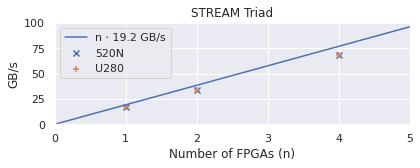

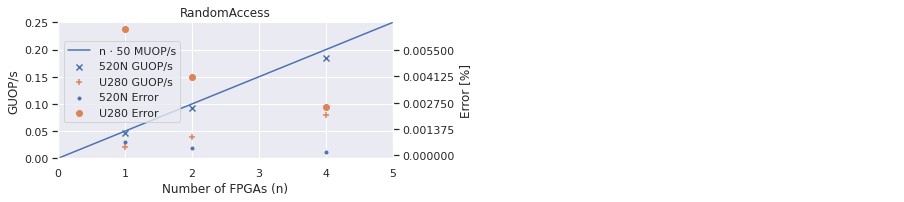

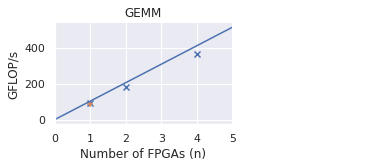

In [26]:
fig, stream = plt.subplots(1, figsize=(6,2.5))
stream.scatter(df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("p520_hpc_sg280l"))]["n"], df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("p520_hpc_sg280l"))]["triad_rate"]* 1.0e-3/4, label="520N", marker="x")
stream.scatter(df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("xilinx"))]["n"], df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("xilinx"))]["triad_rate"]* 1.0e-3/2, label="U280", marker="+")
stream.set_xlabel("Number of FPGAs (n)")
stream.set_ylabel("GB/s")
stream.set_title("STREAM Triad")
stream.set_ylim(0,100)
stream.set_xlim(0,5)
#stream.set_xscale("log")
intel_values = df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("p520_hpc_sg280l"))]["triad_rate"].values * 1.0e-3/4
xilinx_values = df[(df["benchmark"] == "STREAM") & (df["device"].str.contains("xilinx"))]["triad_rate"].values * 1.0e-3/2
count = df[df["benchmark"] == "STREAM"]["n"].values
# stream.plot([0,27], [0, 27 * intel_values[0]], label="n ⋅ %.1f GB/s" % (intel_values[0] * 1.0e3))
# stream.plot([0,27], [0, 27 * xilinx_values[0]], label="n ⋅ %.1f GB/s" % (xilinx_values[0] * 1.0e3))
stream.plot([0,5], [0, 5* 19.2], label="n ⋅ 19.2 GB/s")
#stream.grid(which="major", linestyle="--", color="gray", axis="y")
stream.spines["right"].set_visible(False)
stream.spines["top"].set_visible(False)
stream.legend(loc="upper left", bbox_to_anchor=(0,1))
fig.tight_layout()
fig.savefig("stream_scaling_performance.pdf")

fig, ra = plt.subplots(1, figsize=(6,2.5))
ra.scatter(df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("p520_hpc_sg280l"))]["n"], df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("p520_hpc_sg280l"))]["gops"]/4, label="520N GUOP/s", marker="x")
ra.scatter(df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("xilinx"))]["n"], df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("xilinx"))]["gops"]/2, label="U280 GUOP/s", marker="+")
ra.set_xlabel("Number of FPGAs (n)")
ra.set_ylabel("GUOP/s")
ra.set_title("RandomAccess")
ra.set_ylim(0,0.25)
ra.set_xlim(0,5)
ra.set_xticks([0,1,2,3,4,5])
values = df[df["benchmark"] == "RandomAccess"]["gops"].values
count = df[df["benchmark"] == "RandomAccess"]["n"].values
ra.plot(np.linspace(0,5), np.linspace(0,5) * (0.3/6), label="n ⋅ 50 MUOP/s")
#ra.plot(np.linspace(0,5), np.linspace(0,5) * (0.3/12))
#ra.annotate("%.1f" % values[0], (count[0] + 0.5, values[0] - 100))
#ra.annotate("%.1f" % values[1], (count[1] + 0.5, values[1] - 130))
#ra.annotate("%.1f" % values[2], (count[2] - 0.5, values[2] - 130 ))
#ra.annotate("%.1f" % values[3], (count[3] - 1, values[3] - 130))
#ra.annotate("%.1f" % values[4], (count[4] - 1, values[4] - 130))

ra_error = ra.twinx()
ra_error.scatter(df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("p520_hpc_sg280l"))]["n"], df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("p520_hpc_sg280l"))]["error"], label="520N Error", marker=".")
ra_error.scatter(df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("xilinx"))]["n"], df[(df["benchmark"] == "RandomAccess") & (df["device"].str.contains("xilinx"))]["error"], label="U280 Error", marker="o")
ra_error.set_ylabel("Error [%]")
# ra_error.set_ylim(0,1.0e-3)
ra_error.set_yticks(np.linspace(0, 0.0055, 5))
#ra_error.set_yticks([6.0e-3/0.75 * 0.2,6.0e-3/0.75 * 0.4,6.0e-3/0.75 * 0.6])
#ra.plot([0,18], [0.440,.440], linestyle="--", color="darkblue", alpha=0.7, label="440 MUOP/s")
#ra.grid(which="major", linestyle="--", color="gray", axis="y")
ra.spines["top"].set_visible(False)
ra_error.spines["top"].set_visible(False)
ra_error.annotate("n ⋅ %.1f MUOP/s" % (values[0] * 1.0e3), (11,0.0003))
ra_error.grid(None)

lines, labels = ra.get_legend_handles_labels()
lines2, labels2 = ra_error.get_legend_handles_labels()
ra_error.legend(lines + lines2, labels + labels2, loc="upper left", bbox_to_anchor=(0.0,.9))
fig.tight_layout()
fig.savefig("ra_scaling_performance.pdf")

# fig, fft = plt.subplots(1, figsize=(6,2.5))

# fft.scatter(df[df["benchmark"] == "FFT"]["n"], df[df["benchmark"] == "FFT"]["best_flops"] * 1.0e-3, marker="x")
# fft.set_xlabel("Number of FPGAs (n)")
# fft.set_ylabel("TFLOP/s")
# fft.set_title("FFT")
# fft.set_ylim(0,10)
# fft.set_xlim(0,27)
# values = df[df["benchmark"] == "FFT"]["best_flops"].values * 1.0e-3
# fft.annotate("n ⋅ %.1f GFLOP/s" % (values[0] * 1.0e3), (6,6))
# #fft.annotate("%.2f" % values[0], (df[df["benchmark"] == "FFT"]["n"][0] + 1, values[0] - 0.3))
# #fft.annotate("%.2f" % values[1], (df[df["benchmark"] == "FFT"]["n"][1] + 1, values[1] - 0.3))
# #fft.annotate("%.2f" % values[2], (df[df["benchmark"] == "FFT"]["n"][2] +1, values[2] - 0.3))
# #fft.annotate("%.2f" % values[3], (df[df["benchmark"] == "FFT"]["n"][3] - 1, values[3]- 1))
# fft.plot([0,27], [0, 27 * values[0]])
# #fft.grid(which="major", linestyle="--", color="gray", axis="y")
# fft.spines["right"].set_visible(False)
# fft.spines["top"].set_visible(False)
# fig.tight_layout()
# fig.savefig("fft_scaling_performance.pdf")

fig, gemm = plt.subplots(1, figsize=(6,2.5))

gemm.scatter(df[(df["benchmark"] == "GEMM") & (df["device"].str.contains("p520_hpc_sg280l"))]["n"], df[(df["benchmark"] == "GEMM") & (df["device"].str.contains("p520_hpc_sg280l"))]["gflops"]/5/272.5*100, marker="x", label="520N")
gemm.scatter(df[(df["benchmark"] == "GEMM") & (df["device"].str.contains("xilinx"))]["n"], df[(df["benchmark"] == "GEMM") & (df["device"].str.contains("xilinx"))]["gflops"]/3/186*100, marker="+", label="U280")
gemm.set_xlabel("Number of FPGAs (n)")
gemm.set_ylabel("GFLOP/s")
gemm.set_title("GEMM")
gemm.set_xlim(0,5)
#gemm.set_xscale("log")
values = df[df["benchmark"] == "GEMM"]["gflops"].values
gemm.annotate("n ⋅ %.1f GFLOP/s" % (values[0]), (6,22))
#gemm.annotate("%.2f" % values[0], (df[df["benchmark"] == "GEMM"]["n"][0] + 1, values[0] - 0.3))
#gemm.annotate("%.2f" % values[1], (df[df["benchmark"] == "GEMM"]["n"][1] + 1, values[1] - 0.3))
#gemm.annotate("%.2f" % values[2], (df[df["benchmark"] == "GEMM"]["n"][2] +1, values[2] - 0.3))
#gemm.annotate("%.2f" % values[3], (df[df["benchmark"] == "GEMM"]["n"][3] - 1, values[3]- 1))
gemm.plot([0,5], [0, 5 * 102.4])
#gemm.grid(which="major", linestyle="--", color="gray", axis="y")
gemm.spines["right"].set_visible(False)
gemm.spines["top"].set_visible(False)

fig.tight_layout()

fig.savefig("gemm_scaling_performance.pdf")